In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
df_train=pd.read_csv('creditcard_train.csv')

df_test=pd.read_csv("creditcard_test.csv")

### Check missing value and then using upsampling

Class 0: 227394
Class 1: 395
Proportion: 575.68 : 1


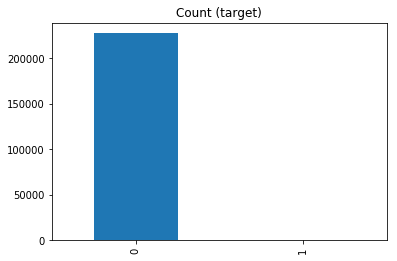

In [24]:
target_count=df_train.Class.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [26]:
##Normalize the amount
from sklearn.preprocessing import StandardScaler
import numpy as np
df_train['normAmount'] = StandardScaler().fit_transform(np.array(df_train['Amount']).reshape(-1, 1))
df_train = df_train.drop(['Time','Amount'],axis=1)
df_train.head()

,Id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.245871
1,1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.340093
2,2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.159293
3,3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.141703
4,4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.071697


### Downsampling

In [27]:
from sklearn.utils import resample

unfraud = df_train[df_train.Class == 0]
fraud = df_train[df_train.Class == 1]

df_down_sampling = pd.concat([resample(unfraud,
                     replace = False,
                     n_samples = len(fraud)), fraud])

In [28]:
df_down_sampling.Class.value_counts()

1    395
0    395
Name: Class, dtype: int64

In [30]:
df_down_sampling.head()

,Id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
33186,41617,-2.985294,-2.747472,1.194068,-0.003036,-1.151041,-0.263559,0.553500,0.635600,0.438545,...,0.373760,-0.385777,1.197596,0.407229,0.008013,0.762362,-0.299024,-0.303929,0,1.703023
10883,13607,-0.502693,0.851534,0.992914,0.491266,0.656654,0.352736,0.530327,-0.202775,1.234209,...,-0.325728,-0.480220,-0.154856,-1.004888,-0.304983,0.286837,-0.130530,0.148985,0,-0.214669
154332,193134,-0.159285,1.069862,0.182417,0.340420,-0.611223,1.182677,-2.536221,-5.084167,-0.445512,...,-2.632487,0.569307,0.465868,-0.414534,-0.478578,0.100357,0.165899,0.369470,0,-0.330920
5825,7290,-2.113476,2.609807,0.884548,2.762924,0.033198,1.025370,-0.887785,-2.626698,-0.367590,...,2.632785,-2.131769,0.475557,-0.167149,0.086450,-0.059007,0.013080,-0.014830,0,-0.302526
107398,134317,0.994359,-0.051218,-0.000052,1.089265,0.199812,0.179679,0.247549,-0.095310,-0.137514,...,0.100340,0.139819,-0.279029,-0.728462,0.645398,-0.265331,0.021581,0.037848,0,0.184375


In [31]:
from sklearn.cross_validation import train_test_split

train_y_down= df_down_sampling.Class
train_x_down= df_down_sampling.drop(['Class',"Id"],axis=1)


In [36]:
df_test['normAmount'] = StandardScaler().fit_transform(np.array(df_test['Amount']).reshape(-1, 1))
test_x = df_test.drop(["Id",'Time','Amount'],axis=1)
test_x.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
0,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,0.309755,...,0.125992,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.322656
1,-0.436905,0.918966,0.924591,-0.727219,0.915679,-0.127867,0.707642,0.087962,-0.665271,-0.737980,...,-0.047021,-0.194796,-0.672638,-0.156858,-0.888386,-0.342413,-0.049027,0.079692,0.131024,-0.359411
2,-5.401258,-5.450148,1.186305,1.736239,3.049106,-1.763406,-1.559738,0.160842,1.233090,0.345173,...,-2.196848,-0.503600,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,-0.173978
3,0.694885,-1.361819,1.029221,0.834159,-1.191209,1.309109,-0.878586,0.445290,-0.446196,0.568521,...,-0.138334,-0.295583,-0.571955,-0.050881,-0.304215,0.072001,-0.422234,0.086553,0.063499,0.572885
4,1.322707,-0.174041,0.434555,0.576038,-0.836758,-0.831083,-0.264905,-0.220982,-1.071425,0.868559,...,-0.522951,-0.284376,-0.323357,-0.037710,0.347151,0.559639,-0.280158,0.042335,0.028822,-0.298381


In [37]:
print(len(train_x_down))
print(len(train_y_down))
print(len(test_x))
# print(len(test_y_down))

790
790
57018


### Upsampling

In [60]:
df_up_sampling = pd.concat([resample(fraud,
                     replace = True,
                     n_samples = len(unfraud)), unfraud])
df_up_sampling.Class.value_counts()

1    227394
0    227394
Name: Class, dtype: int64

In [62]:
train_y_up= df_up_sampling.Class
train_x_up= df_up_sampling.drop(['Class','Id'],axis=1)

# Whole dataset
print(len(train_x_up))
print(len(train_y_up))


454788
454788


In [39]:
def get_predictions(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 
    return y_pred, y_pred_prob

In [40]:
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(len(y_train_data),10,shuffle=False) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100,1000]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],pd.DataFrame(y_train_data).iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(pd.DataFrame(y_train_data).iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')
    

    best_c = results_table.loc[results_table['Mean recall score'].astype("float64").idxmax()]['C_parameter']

    
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [16]:
# import itertools

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=0)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         #print("Normalized confusion matrix")
#     else:
#         1#print('Confusion matrix, without normalization')

#     #print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

### Model for downsampling

In [41]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
logisticRegr = LogisticRegression()
logisticRegr.fit(train_x_down,train_y_down)
y_pred = logisticRegr.predict(test_x)
y_pred_proba = logisticRegr.predict_proba(test_x)[:, 1]
# [fpr, tpr, thr] = roc_curve(test_y_down, y_pred_proba)
print('Train/Test split results:')
# print(logisticRegr.__class__.__name__+" accuracy is %2.3f" % accuracy_score(test_y_down, y_pred))
# print(logisticRegr.__class__.__name__+" log_loss is %2.3f" % log_loss(test_y_down, y_pred_proba))
# print(logisticRegr.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:


In [42]:
best_c = printing_Kfold_scores(train_x_down,train_y_down)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.0
Iteration  2 : recall score =  0.0
Iteration  3 : recall score =  0.0
Iteration  4 : recall score =  0.0
Iteration  5 : recall score =  0.0
Iteration  6 : recall score =  0.9493670886075949
Iteration  7 : recall score =  0.8607594936708861
Iteration  8 : recall score =  0.8734177215189873
Iteration  9 : recall score =  0.9113924050632911
Iteration  10 : recall score =  0.9113924050632911

Mean recall score  0.4506329113924051

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.0
Iteration  2 : recall score =  0.0
Iteration  3 : recall score =  0.0
Iteration  4 : recall score =  0.0
Iteration  5 : recall score =  0.0
Iteration  6 : recall score =  0.9620253164556962
Iteration  7 : recall score =  0.8607594936708861
Iteration  8 : recall score =  0.87341772151

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_

Iteration  1 : recall score =  0.0
Iteration  2 : recall score =  0.0
Iteration  3 : recall score =  0.0
Iteration  4 : recall score =  0.0
Iteration  5 : recall score =  0.0
Iteration  6 : recall score =  0.8987341772151899
Iteration  7 : recall score =  0.8734177215189873
Iteration  8 : recall score =  0.8860759493670886
Iteration  9 : recall score =  0.9240506329113924
Iteration  10 : recall score =  0.9113924050632911

Mean recall score  0.44936708860759494

-------------------------------------------
C parameter:  100
-------------------------------------------



D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  1 : recall score =  0.0
Iteration  2 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  3 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  4 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  5 : recall score =  0.0
Iteration  6 : recall score =  0.9746835443037974
Iteration  7 : recall score =  0.8860759493670886
Iteration  8 : recall score =  0.8987341772151899
Iteration  9 : recall score =  0.9367088607594937
Iteration  10 : recall score =  0.9113924050632911

Mean recall score  0.46075949367088603

-------------------------------------------
C parameter:  1000
-------------------------------------------

Iteration  1 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  2 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  3 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  4 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  5 : recall score =  0.0
Iteration  6 : recall score =  0.9746835443037974
Iteration  7 : recall score =  0.8860759493670886
Iteration  8 : recall score =  0.8987341772151899
Iteration  9 : recall score =  0.9367088607594937
Iteration  10 : recall score =  0.9113924050632911

Mean recall score  0.46075949367088603

*********************************************************************************
Best model to choose from cross validation is with C parameter =  100.0
*********************************************************************************


In [21]:
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
# from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
# logisticRegr.fit(train_x_down,train_y_down)
# y_pred = logisticRegr.predict(test_x_down)
# print("F1 Score for the logistic regression %2.3f percent" % (f1_score(test_y_down, y_pred)*100))

In [43]:
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(train_x_down,train_y_down.values.ravel())
y_pred_undersample = lr.predict(test_x.values)

# Compute confusion matrix
# cnf_matrix = confusion_matrix(test_y_down,y_pred_undersample)
# np.set_printoptions(precision=2)

# print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# # Plot non-normalized confusion matrix
# class_names = [0,1]
# plt.figure()
# plot_confusion_matrix(cnf_matrix
#                       , classes=class_names
#                       , title='Confusion matrix')
# plt.show()

In [41]:
## SVM

In [51]:
from sklearn.svm import SVC
from sklearn import metrics
svc=SVC(kernel="linear") #Default hyperparameters
svc.fit(train_x_down,train_y_down)
y_pred=svc.predict(test_x)

### SVM is not suitable for this fraud detect, use random forest instead

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score
from sklearn.grid_search import GridSearchCV

clf = DecisionTreeClassifier()

parameters = parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)},{'min_samples_split': (0.1,0.2,0.3,0.4,0.5)},{'min_samples_leaf': (1,2,3,4,5,6,7)},{'min_weight_fraction_leaf': (0.0,0.1,0.2)}
scorer = make_scorer(fbeta_score,beta=0.5)

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer)
grid_fit = grid_obj.fit(train_x_down,train_y_down)

best_clf = grid_fit.best_estimator_
predictions = (clf.fit(train_x_down, train_y_down)).predict(test_x)
best_predictions = best_clf.predict(test_x)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [29]:
print("F1 Score for the decision tree is %2.3f percent" % (f1_score(test_y_down, best_predictions)*100))

F1 Score for the decision tree is 46.981 percent


In [37]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

random_forest = RandomForestClassifier(n_estimators=100,oob_score=True,max_features=5)

random_forest.fit(train_x_down,train_y_down)

rf_y_pred = random_forest.predict(test_x_down)


In [38]:
print("F1 Score for the random forest is %2.3f percent" % (f1_score(test_y_down, rf_y_pred)*100))

F1 Score for the random forest is 48.795 percent


Recall metric in the testing dataset:  0.47234730400646574


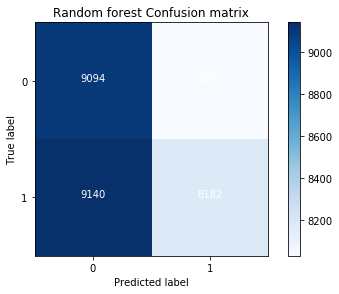

In [39]:
cnf_matrix = confusion_matrix(test_y_down,rf_y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Random forest Confusion matrix')
plt.show()

In [32]:
##Naive bayes
from sklearn.naive_bayes import GaussianNB
import numpy as np
y_pred_NB, y_pred_prob = get_predictions(GaussianNB(), train_x_down, train_y_down, test_x_down)
# Compute confusion matrix

train-set confusion matrix:
 [[39651   636]
 [39183   908]]


In [33]:
print("F1 Score for the Naive Bayes is %2.3f percent" % (f1_score(test_y_down, y_pred_NB)*100))

F1 Score for the Naive Bayes is 4.580 percent


Recall metric in the testing dataset:  0.023842512411961666


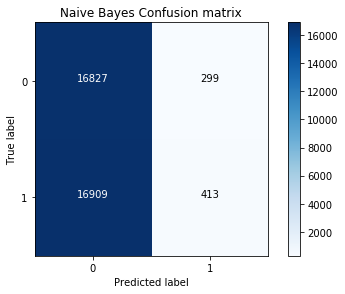

In [35]:
cnf_matrix = confusion_matrix(test_y_down,y_pred_NB)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Naive Bayes Confusion matrix')
plt.show()

## Downsampling did not do well on this test, try upsampling here

In [41]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
logisticRegr.fit(train_x_up,train_y_up)
y_pred_log_up,y_pred_prb = get_predictions(LogisticRegression(), train_x_up, train_y_up, test_x_up)
print("F1 Score for the logistic regression %2.3f percent" % (f1_score(test_y_up, y_pred_log_up)*100))

train-set confusion matrix:
 [[111907  47377]
 [110106  48961]]
F1 Score for the logistic regression 38.174 percent


In [255]:
##Hyperparameter for Logit
best_c = printing_Kfold_scores(train_x_up,train_y_up)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.9215242199696563
Iteration  2 : recall score =  0.9239209305393699
Iteration  3 : recall score =  0.9191714857406715
Iteration  4 : recall score =  0.9220519360584006
Iteration  5 : recall score =  0.9208848234311096


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  6 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  7 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  8 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  9 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Iteration  10 : recall score =  0.0

Mean recall score  0.4607553395739208

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.9215242199696563
Iteration  2 : recall score =  0.9239209305393699
Iteration  3 : recall score =  0.9191714857406715
Iteration  4 : recall score =  0.9220519360584006
Iteration  5 : recall score =  0.9208848234311096


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  6 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  7 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  8 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  9 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  10 : recall score =  0.0

Mean recall score  0.4607553395739208

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.9215242199696563
Iteration  2 : recall score =  0.9239209305393699
Iteration  3 : recall score =  0.9191714857406715
Iteration  4 : recall score =  0.9220519360584006
Iteration  5 : recall score =  0.9208848234311096


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  6 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  7 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  8 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  9 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  10 : recall score =  0.0

Mean recall score  0.4607553395739208

-------------------------------------------
C parameter:  10
-------------------------------------------

Iteration  1 : recall score =  0.9215242199696563
Iteration  2 : recall score =  0.9239209305393699
Iteration  3 : recall score =  0.9191714857406715
Iteration  4 : recall score =  0.9220519360584006
Iteration  5 : recall score =  0.9208848234311096


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  6 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  7 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  8 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  9 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  10 : recall score =  0.0

Mean recall score  0.4607553395739208

-------------------------------------------
C parameter:  100
-------------------------------------------

Iteration  1 : recall score =  0.9215242199696563
Iteration  2 : recall score =  0.9239209305393699
Iteration  3 : recall score =  0.9191714857406715
Iteration  4 : recall score =  0.9220519360584006
Iteration  5 : recall score =  0.9208848234311096


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  6 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  7 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  8 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  9 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  10 : recall score =  0.0

Mean recall score  0.4607553395739208

-------------------------------------------
C parameter:  1000
-------------------------------------------

Iteration  1 : recall score =  0.9215242199696563
Iteration  2 : recall score =  0.9239209305393699
Iteration  3 : recall score =  0.9191714857406715
Iteration  4 : recall score =  0.9220519360584006
Iteration  5 : recall score =  0.9208848234311096


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  6 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  7 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  8 : recall score =  0.0


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Iteration  9 : recall score =  0.0
Iteration  10 : recall score =  0.0

Mean recall score  0.4607553395739208

*********************************************************************************
Best model to choose from cross validation is with C parameter =  0.01
*********************************************************************************


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Recall metric in the testing dataset:  0.022343821249430004


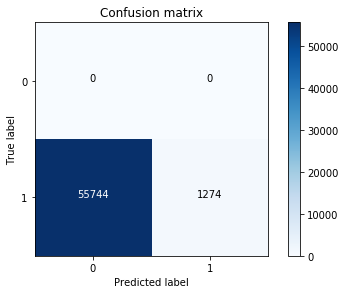

In [258]:
lr = LogisticRegression(C = best_c, penalty = 'l2')
lr.fit(train_x_up,train_y_up.values.ravel())
y_pred_upsample = lr.predict(x_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_upsample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [250]:
##Naive bayes
from sklearn.naive_bayes import GaussianNB
import numpy as np
y_pred_NB_up, y_pred_prob = get_predictions(GaussianNB(), train_x_up, train_y_up, x_test)

train-set confusion matrix:
 [[226554    840]
 [ 94373 133021]]


Recall metric in the testing dataset:  0.004963344908625347


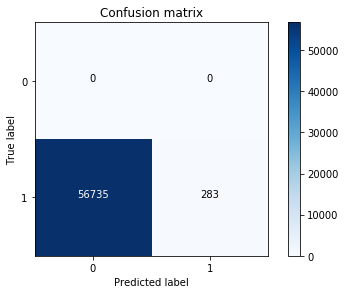

In [251]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_NB_up)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [46]:
print("F1 Score for the Naive Bayes is %2.3f percent" % (f1_score(y_test, y_pred)*100))

F1 Score for the Naive Bayes is 1.127 percent


In [63]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

random_forest = RandomForestClassifier(n_estimators=1000,oob_score=True,max_features='auto')

random_forest.fit(train_x_up, train_y_up)

rf_y_pred = random_forest.predict(test_x)

In [65]:
submission=pd.read_csv("sample_submission.csv")
submission.Class=rf_y_pred
submission.to_csv("submission.csv",index=False)

In [46]:
ls

 Volume in drive C is Windows
 Volume Serial Number is A0AC-92BA

 Directory of C:\Users\65451\Desktop\Columbia\Lintcode_project\AML

06/17/2019  08:03 PM    <DIR>          .
06/17/2019  08:03 PM    <DIR>          ..
05/26/2019  03:29 PM    <DIR>          .ipynb_checkpoints
06/17/2019  08:03 PM           165,215 Anti-fraud.ipynb
05/26/2019  03:27 PM        20,867,597 creditcard_test.csv
05/26/2019  03:27 PM        83,820,063 creditcard_train.csv
05/26/2019  03:27 PM           547,948 sample_submission.csv
05/26/2019  03:27 PM               490 scorer.py
               5 File(s)    105,401,313 bytes
               3 Dir(s)  56,387,411,968 bytes free


In [64]:
rf_y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)